# Step 1: Clone the repository

Clone the git repository so train, validation and test data can be accessed in this notebook

In [1]:
! git clone https://github.com/ysharma12/VIntel.git
! ls

fatal: destination path 'VIntel' already exists and is not an empty directory.
sample_data  vgg_updated.png  VIntel


# Step 2: Import modules

In [0]:
import os
import sys
import keras
import numpy as np
import random
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import sklearn.metrics as sklm
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense,  Dropout, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Conv2D
from keras.models import Model,Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras import backend as K
import tensorflow as tf
from scipy import misc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

img_dim_ordering = 'tf'
K.set_image_dim_ordering(img_dim_ordering)

# Visualisation
%matplotlib inline
import matplotlib.pyplot as plt

# Step 3: Check for GPU run time

In [3]:
tf.test.gpu_device_name()
tf.test.is_gpu_available()

True

# Step 4: Create and compile the model

In [0]:
def get_pretrained_model():
  """Loads and modifies the VGG16 model for 10 classes"""
  model_vgg16 = VGG16(weights='imagenet', include_top=False)

  #freezing all layers
  for layer in model_vgg16.layers:
    layer.trainable = False

  #Setting input format
  keras_input = Input(shape=(224,224,3), name = 'image_input')

  #new vgg16 model 
  output_vgg16_conv = model_vgg16(keras_input)

  #New layers for 10 class classification
  new = Flatten(name='flatten')(output_vgg16_conv)
  new = Dense(4096, activation='relu', name='fc1')(new)
  new = Dense(4096, activation='relu', name='fc2')(new)
  new = Dense(10, activation='softmax', name='predictions')(new)

  pretrained_model = Model(inputs=keras_input, outputs=new)
  print("Compiling model ...")
#   pretrained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  pretrained_model.compile(loss='categorical_crossentropy',  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
  print("Finished model compiling ...")

  return pretrained_model  



# Step 5: Create image generators

In [0]:
def get_train_generator():
  """Creates a data generator with train images"""

  train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(
        'VIntel/train', # train directory
        target_size=(224, 224),  # all images get resized to 224x224
        batch_size=50,
        class_mode='categorical')

  return train_generator    


def get_validation_generator():
  """Creates a data generator with validation images"""

  validation_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

  validation_generator = validation_datagen.flow_from_directory(
        'VIntel/valid', # validation directory
        target_size=(224, 224),
        batch_size=59,
        shuffle=False,
        class_mode='categorical')    

  return validation_generator 


def get_test_generator():
  """Creates a data generator with test images"""
  test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
  
  test_generator = test_datagen.flow_from_directory(
        'VIntel/test',
        target_size=(224, 224),
        batch_size=59,
        shuffle=False,
        class_mode='categorical')    
  return test_generator

# Step 6: Helper functions for plotting

In [0]:
# def prep_valid(input):  ####prepr export to csv
#   out1=[]
#   out2=[]
#   for l in input:
#     out1.append(l[0])
#     out2.append(l[1])
#   return np.asarray(out1),np.asarray(out2)


def plot_training_history(history):
  """Plots training history with loss and accuracy for each epoch"""
  acc = history.history['acc']
  loss = history.history['loss']
  epochs = range(len(acc))

  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'go-', label='training acc')
  plt.title('Training accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'ro-', label='training loss')
  plt.title('Training loss')
  plt.legend()
  plt.show()
  
from keras.utils.vis_utils import plot_model
def get_model_plot():
  model = VGG16()
  plot_model(model, to_file='vgg_original.png')
  
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(18, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Step 7: Model training

In [20]:
print("getting train generator...")  
train_generator = get_train_generator()  
print("getting model...")  
model = get_pretrained_model()
print("Starting training...")
history = model.fit_generator(
        train_generator,
        steps_per_epoch=223, # batch_size 
        epochs=150)
print("Saving model...")          
model.save("model_vintel_02_150_epochs")


getting train generator...
Found 1784 images belonging to 10 classes.
getting model...
Compiling model ...
Finished model compiling ...
Starting training...
Epoch 1/2
223/223 [==============================] - 312s 1s/step - loss: 1.8231 - acc: 0.4100
Epoch 2/2
223/223 [==============================] - 304s 1s/step - loss: 1.4045 - acc: 0.5777
Saving model...


# Step 8: Plot training loss and accuracy

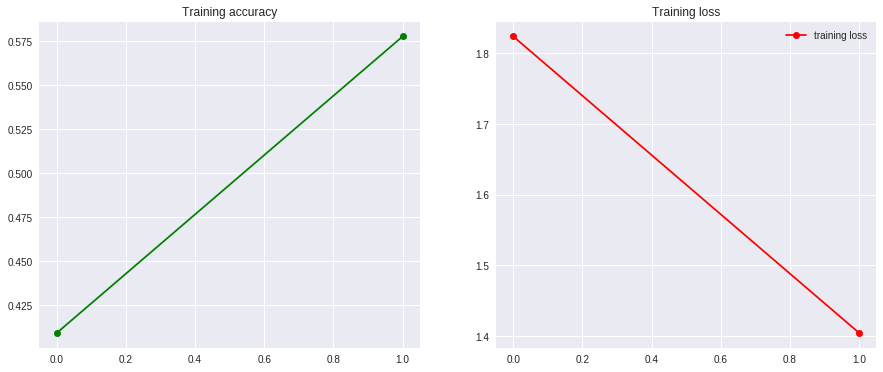

In [23]:
plot_training_history(history)


# Step 9: Model validation

In [48]:
print("getting validation generator...")
validation_generator = get_validation_generator()
print(validation_generator.class_indices)
batch_valid = 59
num_steps = 10
y = validation_generator.classes
# print("Model predictions")
valid_pred = model.predict_generator(validation_generator, steps=10, verbose=1)       
print(valid_pred.shape)
y_valid = np.argmax(valid_pred, axis=1)
# print('Confusion Matrix')
cm = confusion_matrix(y, y_valid)
# print(cm)

score = model.evaluate_generator(validation_generator, steps=10)
print(score)
print("Validation Loss:", score[0])
print("Validation Accuracy:", score[1])


getting validation generator...
Found 590 images belonging to 10 classes.
{'bar_stool': 0, 'bookcase': 1, 'chandelier': 2, 'dining_chair': 3, 'market_umbrella': 4, 'night_stands': 5, 'ottoman': 6, 'sconces': 7, 'table_lamp': 8, 'vases': 9}
10/10 [==============================] - 16s 2s/step
(590, 10)
[1.3388429164886475, 0.5864406853914261]
Validation Loss: 1.3388429164886475
Validation Accuracy: 0.5864406853914261


Confusion matrix, without normalization
[[15  2  0  4  0  0  0  2  0  1]
 [ 6 67  2  4  5  0  0  3  2  3]
 [ 2  0 62  0  2  0  2  7  4  7]
 [18  3  4 54  1  1  2  6  3  2]
 [ 2  0  2  3 37  0  3  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  2  0 29  0  1  2]
 [11 10 41  9 17  5  0 57 23  8]
 [ 0  0  0  0  1  0  0  1 13  1]
 [ 0  0  0  0  0  0  0  0  0 14]]
Normalized confusion matrix
[[0.625      0.08333333 0.         0.16666667 0.         0.
  0.         0.08333333 0.         0.04166667]
 [0.06521739 0.72826087 0.02173913 0.04347826 0.05434783 0.
  0.         0.0326087  0.02173913 0.0326087 ]
 [0.02325581 0.         0.72093023 0.         0.02325581 0.
  0.02325581 0.08139535 0.04651163 0.08139535]
 [0.19148936 0.03191489 0.04255319 0.57446809 0.0106383  0.0106383
  0.0212766  0.06382979 0.03191489 0.0212766 ]
 [0.04166667 0.         0.04166667 0.0625     0.77083333 0.
  0.0625     0.         0.02083333 0.        ]
 [       nan        nan        nan        nan        nan   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


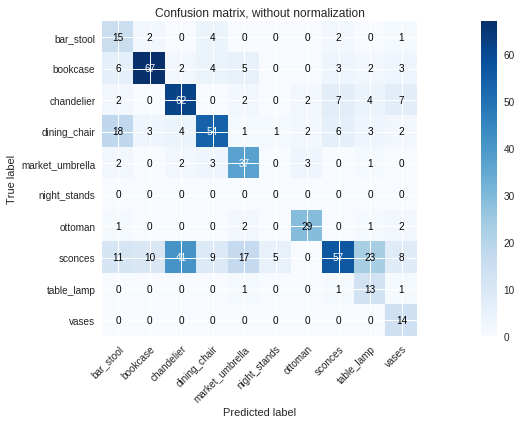

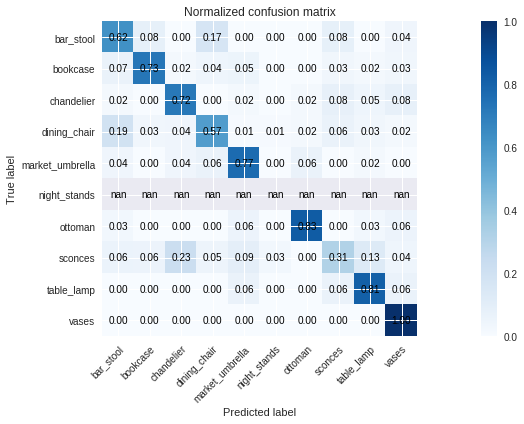

In [49]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_valid, y, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_valid, y, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [50]:
print(classification_report(validation_generator.classes, y_valid, target_names=labels))

                 precision    recall  f1-score   support

      bar_stool       0.62      0.27      0.38        55
       bookcase       0.73      0.82      0.77        82
     chandelier       0.72      0.56      0.63       111
   dining_chair       0.57      0.73      0.64        74
market_umbrella       0.77      0.57      0.65        65
   night_stands       0.00      0.00      0.00         6
        ottoman       0.83      0.81      0.82        36
        sconces       0.31      0.75      0.44        76
     table_lamp       0.81      0.28      0.41        47
          vases       1.00      0.37      0.54        38

      micro avg       0.59      0.59      0.59       590
      macro avg       0.64      0.51      0.53       590
   weighted avg       0.67      0.59      0.59       590



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
model = load_model('model_vintel_02_150_epochs')

OSError: ignored

# Step 10: Model testing

In [61]:
print("getting test generator...")
test_generator = get_test_generator()
print(test_generator.class_indices)
batch_test = 59
num_steps = 10
y = test_generator.classes
# print("Model predictions")
test_pred = model.predict_generator(test_generator, steps=10, verbose=1)       
print(test_pred.shape)
y_test = np.argmax(test_pred, axis=1)
# print('Confusion Matrix')
cm = confusion_matrix(y, y_test)
# print(cm)

score = model.evaluate_generator(test_generator, steps=10)
print(score)
print("test Loss:", score[0])
print("test Accuracy:", score[1])

getting test generator...
Found 590 images belonging to 10 classes.
{'bar_stool': 0, 'bookcase': 1, 'chandelier': 2, 'dining_chair': 3, 'market_umbrella': 4, 'night_stands': 5, 'ottoman': 6, 'sconces': 7, 'table_lamp': 8, 'vases': 9}
10/10 [==============================] - 16s 2s/step
(590, 10)
[1.3554166674613952, 0.5728813648223877]
test Loss: 1.3554166674613952
test Accuracy: 0.5728813648223877


Confusion matrix, without normalization
[[15  1  2  0  0  0  0  2  0  1]
 [ 6 59  2  4  3  3  1 11  4  1]
 [ 2  1 67  1  2  0  1  7  3  3]
 [17  4  9 56  2  0  1  3  3  3]
 [ 1  5  5  1 41  0  0  1  0  2]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  1  1  0 29  1  1  6]
 [12 12 26 11 16  3  4 51 25 15]
 [ 0  0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0  7]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix
[[0.71428571 0.04761905 0.0952381  0.         0.         0.
  0.         0.0952381  0.         0.04761905]
 [0.06382979 0.62765957 0.0212766  0.04255319 0.03191489 0.03191489
  0.0106383  0.11702128 0.04255319 0.0106383 ]
 [0.02298851 0.01149425 0.77011494 0.01149425 0.02298851 0.
  0.01149425 0.08045977 0.03448276 0.03448276]
 [0.17346939 0.04081633 0.09183673 0.57142857 0.02040816 0.
  0.01020408 0.03061224 0.03061224 0.03061224]
 [0.01785714 0.08928571 0.08928571 0.01785714 0.73214286 0.
  0.         0.01785714 0.         0.03571429]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.04878049 0.         0.         0.02439024 0.02439024 0.
  0.70731707 0.02439024 0.02439024 0.14634146]
 [0.06857143 0.06857143 0.14857143 0.06285714 0.09142857 0.01714286
  0.02285714 0.29142857 0.14285714 0.08571429]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.      

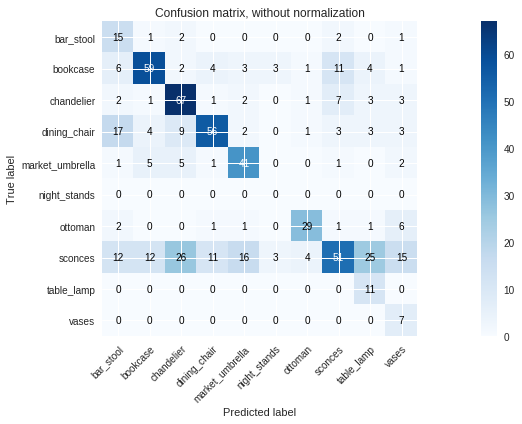

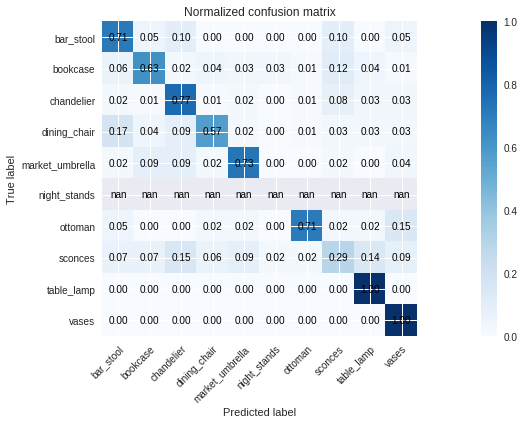

In [62]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Step 11: Test prediction examples

In [64]:
test_classes = test_generator.class_indices
print(test_classes)
decode_test_classes = {v: k for k, v in test_classes.items()}

{'bar_stool': 0, 'bookcase': 1, 'chandelier': 2, 'dining_chair': 3, 'market_umbrella': 4, 'night_stands': 5, 'ottoman': 6, 'sconces': 7, 'table_lamp': 8, 'vases': 9}


In [0]:
num_samples = 20

590
[112, 506, 210, 588, 528, 435, 293, 556, 63, 52, 520, 192, 439, 111, 276, 587, 555, 280, 326, 388]


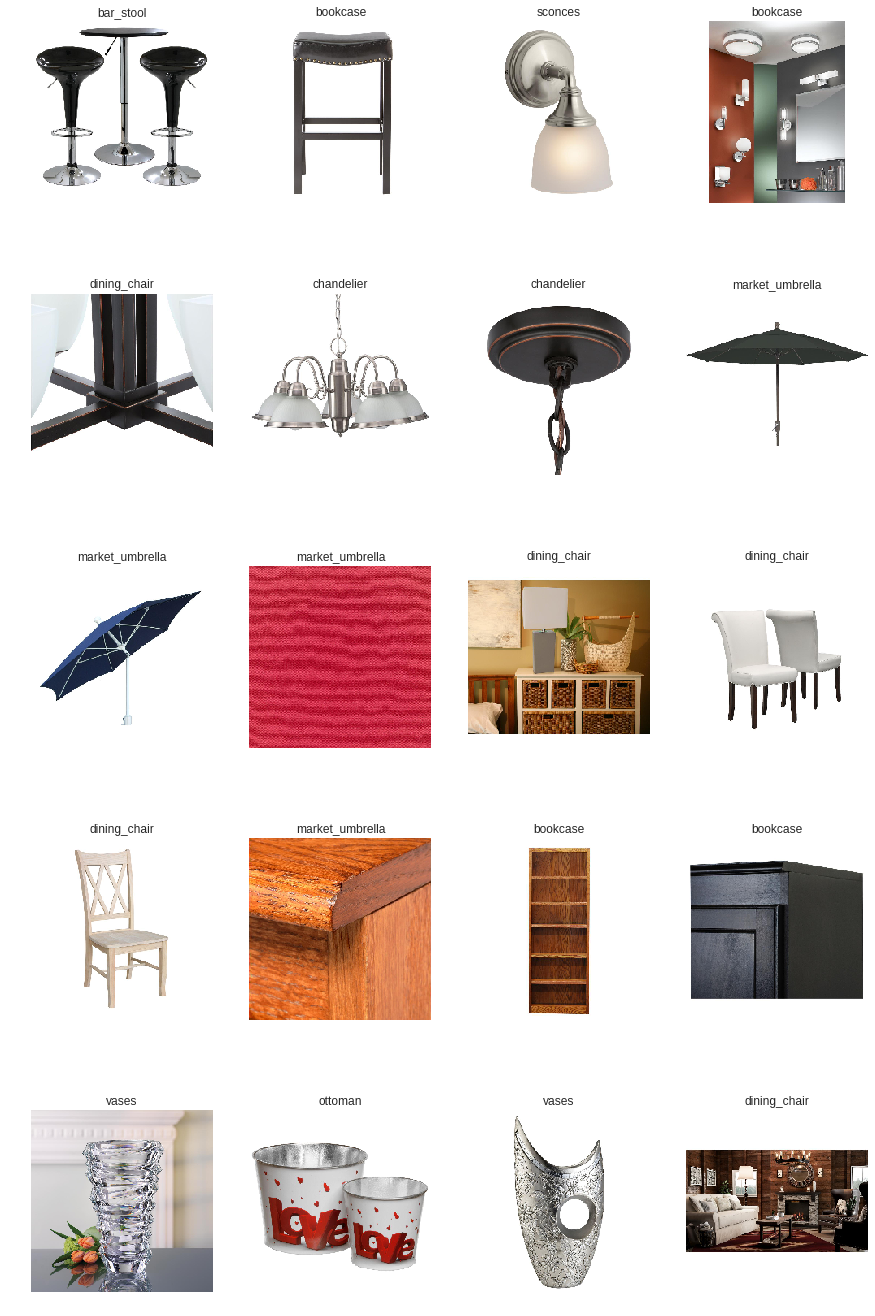

In [70]:
test_dir = 'VIntel/test'

filenames_full = []
for dirpath, dirnames, filenames in os.walk(test_dir):
    for filename in filenames:
      if filename != '.DS_Store':
        filenames_full.append(os.path.join(dirpath, filename))

print(len(filenames_full))
rand_indices = random.sample(range(1, len(filenames_full)), num_samples)
print(rand_indices)
rows = (len(filenames_full) - 1) // 4 + 1
plt.figure(figsize=(15, 5 * rows))
cnt = 0
for index, filename_full in enumerate(filenames_full):
  if index in rand_indices:
    plt.subplot(rows, 4, cnt + 1)
    test_image = keras.preprocessing.image.load_img(filename_full, target_size=(224, 224))
    test_input = keras.preprocessing.image.img_to_array(test_image) * (1. / 255)
    test_input = np.expand_dims(test_input, axis=0)
    plt.imshow(test_image)
    plt.axis('off')
    prediction = model.predict(test_input)
    type_name = decode_test_classes[np.argmax(prediction[0])]
    plt.title(type_name)
    cnt = cnt + 1
    if cnt > num_samples:
      break
